# Thalamocortical loops for fast initial state prepration

## Notebook setup

### Magics

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import numpy as np
import numpy.random as npr
np.set_printoptions(linewidth=200)

from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

from time import time
import inspect

import tensorflow as tf
import tensorflow_probability as tfp

### Version check
We want Tensorflow 2.3 and Tensorflow Probability 0.11

In [3]:
print(f'tf version: {tf.__version__}')
print(f'tfp version: {tfp.__version__}')
print(f'GPUs: {[device.name for device in tf.config.list_physical_devices("GPU")] if len(tf.config.list_physical_devices("GPU")) else None}')

tf version: 2.3.0
tfp version: 0.11.0
GPUs: None


### We will need a custom eigendecompostion operation
Tensorflow's internal `eig` function is single-threaded and __very__ slow. Here we wrap numpy's fast algorithm as a Tensorflow op. We have to provide a custom gradient which has been described in equation 4.77 in [Boeddeker et at. 2017](https://arxiv.org/pdf/1701.00392.pdf "arXiv:1701.00392"). If for matrix $A$, $\Lambda$ is the diagonal matrix of its eigenvalues and $V$ the matrix of its right eigenvectors, then the gradient is given as
$$
\nabla_{A^*}=V^{-\mathsf H}\left[\nabla_{\Lambda^*}+F^*\circ\left(V^\mathsf H\nabla_{V^*} - V^\mathsf HV(V^\mathsf H\nabla_{V^*}\circ I)\right)\right]V^\mathsf H,
$$
where $F_{ii}=0$ and $\forall_{i\ne j}, F_{ij}=(\lambda_j-\lambda_i)^{-1}$, and $\nabla_{\Lambda^*}$ and $\nabla_{V^*}$ are the gradients w.r.t. the conjugates of $\Lambda$ and $V$ (which are backpropogated by Tensorflow).

Note that we have omitted a cast-to-real step in equation 4.77. [@refraction-ray](https://github.com/refraction-ray "@refraction-ray on GitHub") has shown on [their blog](https://re-ra.xyz/Gauge-Problem-in-Automatic-Differentiation "Gauge Problem in Automatic Differentiation") that this step is unnecessary (see equation 19).

In [4]:
# a stable version of 1/x
def _reciprocal(x, ep=1e-20):
    return x / (x * x + ep)

# wrapper of numpy's eig() with custom gradient
@tf.custom_gradient
def _myeig(A):
    e, v = np.linalg.eig(A)
    def grad(grad_e, grad_v):
        f = _reciprocal(e[..., None, :] - e[..., None])
        f = tf.linalg.set_diag(f, tf.zeros_like(e))
        f = tf.math.conj(f)
        vt = tf.linalg.adjoint(v)
        vgv = vt @ grad_v
        mid = tf.linalg.diag(grad_e) + f * (vgv - vt @ (v * tf.linalg.diag_part(vgv)[..., None, :]))
        grad_a = tf.linalg.solve(vt, mid @ vt)
        return tf.cast(grad_a, A.dtype)
    return (e, v), grad

# wrapper of Tensorflow's py_function(), which let's us use our custom op
def myeig(A):
    if A.dtype == tf.float32:
        return tf.py_function(func=_myeig, inp=[A], Tout=[tf.complex64, tf.complex64])
    elif A.dtype == tf.float64:
        return tf.py_function(func=_myeig, inp=[A], Tout=[tf.complex128, tf.complex128])
    else:
        raise NotImplementedError('Expecting tf.float32 or tf.float64')

## Problem setup
Consider a simple linear dynamical system:
$$
\tau\dot x = -x + Jx,
$$
or:
$$
\begin{align}
x(t)&=e^{(J-I)\frac{t}{\tau}}x_0\\
&=Re^{(\Lambda-I)\frac{t}{\tau}}Lx_0\\
&=Re^{\Gamma t}Lx_0,
\end{align}
$$
where $x_0$ is the length-$N$ initial condition vector, $R$ and $L$ are the matrices of right and left eigenvectors of the $N\times N$ weight matrix $J$, $\Lambda$ is the diagonal matrix of the eigenvalues of $J$, $I$ is the identify matrix, and $\Gamma=(\Lambda-I)/\tau$.

We define $J$ as:
$$
J=J_0+UV
$$
with $N\times n$ and $n\times N$ matrices $U$ and $V$ (for $n<N$), and $\left<\left[J_0\right]_{ij}\right>=0$ and $\left<\left[J_0\right]_{ij}^2\right>=1/N$. This means that the eigenspectrum of $J_0$ is uniformly distributed on the unit disc.

### Model parameters
As we learn $U$ and $V$ (see below), we can apply a constraint such that either the columns of $U$ and the rows of $V$ have unit norms (more restrictive) or the elements of the product $UV$ have variance $1/N$ (less restrictive). Or we can leave the weights of $U$ and $V$ unconstrainted. We select these options by setting `normalization_scheme` to `'raw_weights'`, `'perturbation_weights'`, or `'none'`.

In [5]:
# simulation parameters
dt = 0.001  # time step (s)
n_seconds = 0.1  # simultation time at test (s)

# network parameters
tau = 0.01  # neural time constant (s)
N = 200  # network size
n_frac = 0.2  # rank of U and V as fraction of N
normalization_scheme = 'raw_weights'  # normalization for U and V ('raw_weights', 'perturbation_weights', or None)

# random seeds
numpy_seed = 2

### Build model

In [6]:
# set numpy seed
npr.seed(numpy_seed)

# sample J0
J0 = npr.randn(N, N) / np.sqrt(N)

# sample U and V
n = int(round(N * n_frac))  # n from n_frac
sigma_U = sigma_V = 1 / np.sqrt(N)  # default scaling for 'raw weights' option
if normalization_scheme == 'perturbation_weights':
    sigma_U = 1 / (n * N)**0.25
    sigma_V = 1 / (n * N)**0.25
V = npr.randn(n, N) * sigma_V
U = npr.randn(N, n) * sigma_U

# sample w
w = npr.randn(N) / np.sqrt(N)

### Initial eigenvalues of $J_0$ and $J_0+UV$
Let's plot the eigenvalues of $J_0$ and $J_0 + UV$ in the complex plane

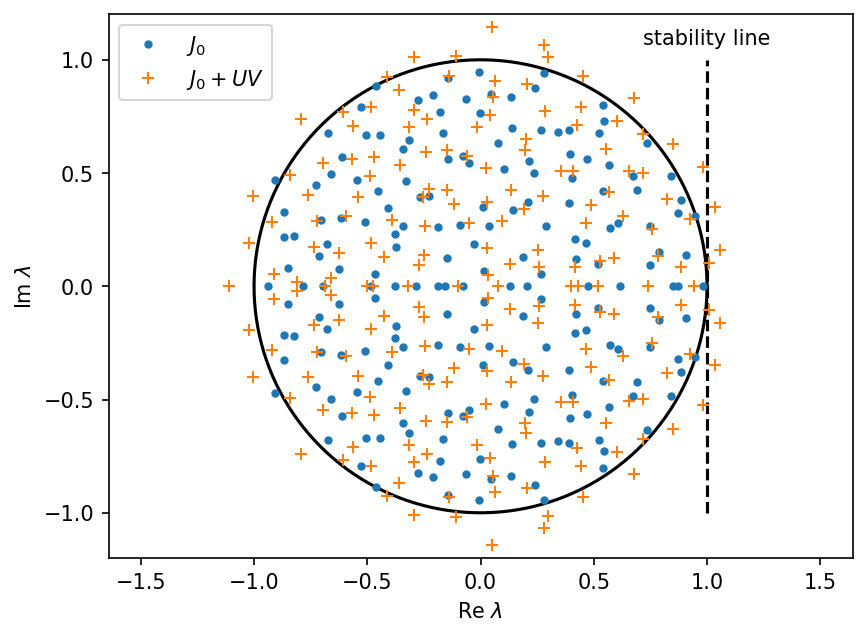

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])
theta = np.linspace(0, 2 * np.pi, 500)
d, v = np.linalg.eig(J0)
d0, v0 = np.linalg.eig(J0 + U @ V)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.plot([1, 1], [-1, 1], '--k')
plt.plot(d.real, d.imag, '.')
plt.plot(d0.real, d0.imag, '+')
plt.xlabel('Re $\lambda$')
plt.ylabel('Im $\lambda$')
plt.text(1, 1.05, 'stability line', ha='center', va='bottom')
plt.axis('equal')
ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
plt.legend(plt.gca().get_children()[2:], ['$J_0$', '$J_0 + UV$']);

## Loss function
Our goal is to find low rank matrices $U$ and $V$ such that $x$ decays to zero as quickly as possible independent of $x_0$. Thus, the first part of our loss function is the integral under the squared norm of $x$ averaged over $x_0$ and normalized by $N$ and $\tau$:
$$
\begin{align}
L_1(U,V)&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ \|x(t)\|^2
\right\}\\
&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ x_0^\mathsf TL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf HRe^{\Gamma t}Lx_0
\right\}\\
&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ \textsf{Tr}\left(Re^{\Gamma t}Lx_0x_0^\mathsf TL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)
\right\}\\
&=\frac{1}{N\tau}\textsf{Tr}\left(\int_0^\infty dt\ Re^{\Gamma t}L\mathbb E_{x_0}\left\{x_0x_0^\mathsf T\right\}L^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)\\
&=\frac{1}{N\tau}\textsf{Tr}\left(\int_0^\infty dt\ Re^{\Gamma t}LL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)\\
&=\frac{1}{N\tau}\textsf{Tr}\left(R\left(LL^\mathsf H\circ F\right)R^\mathsf H\right),
\end{align}
$$
where we assume $x_0$ is centered with covariance $I$ and we define $F$ such that $F_{ij}=-1/(\gamma_i + \gamma_j^*)$ with $\gamma_i$ as the $i^\textsf{th}$ diagonal element of $\Gamma$.

This loss is only sensical if $\forall_i,\textsf{Re}(\lambda_i)<1$ (see dotted line above). Thus we add a penalty to enforce this:
$$
\begin{align}
L_2(U,V)&=\sum_i\max(\textrm{Re}(\gamma_i),0)^2.
\end{align}
$$

Finally, the output of our system is given as $y=w^\mathsf Tx$ and, during the decay of $x$, we desired this output to be smooth. Thus we add to following term to our loss:
$$
\begin{align}
L_3(U,V) &=\frac{1}{\tau}\mathbb E_{x_0}\left\{\int_0^\infty dt\ \left(\tau\frac{d}{dt}w^\mathsf Tx\right)^2\right\}\\
&=\tau\,\mathbb E_{x_0}\left\{\int_0^\infty dt\ \left(w^\mathsf TRe^{\Gamma t}\Gamma Lx_0\right)^2\right\}\\
%&=\mathbb E_{x_0}\left\{\int_0^\infty dt\ w^\mathsf TRe^{\Gamma t}\Gamma Lx_0x_0^\mathsf TL^\mathsf H\Gamma^\mathsf He^{\Gamma^\mathsf H t}R^\mathsf Hw\right\}\\
&=\tau\int_0^\infty dt\ w^\mathsf TRe^{\Gamma t}\Gamma LL^\mathsf H\Gamma^\mathsf He^{\Gamma^\mathsf H t}R^\mathsf Hw\\
&=\tau\,w^\mathsf TR(LL^\mathsf H\circ G)R^\mathsf Hw,
\end{align}
$$
where we define $G$ such that $G_{ij}=\gamma_i\gamma_j^*F_{ij}$.

Our total loss is thus:
$$
\mathcal L(U,V) = L_1(U,V) + \alpha L_2(U,V) + \beta L_3(U,V),
$$
where $\alpha$ and $\beta$ are hyperparameters weighting the importance of $L_2$ and $L_3$ relative to $L_1$.

### Loss parameters

In [8]:
# penalty for solutions that don't decay
alpha = 1e5

# smoothness constraint
beta = 0.01

### Loss function code

In [9]:
# param is a 1-d tensor; reshape to 2 x N x n tensor, then extract U & V.T; renormalize U & V.T if needed; return U and V
def _extract_U_and_V(param):
    param = tf.reshape(param, (2, N, -1))
    U, V = param[0], param[1]
    if normalization_scheme == 'raw_weights' or normalization_scheme == 'perturbation_weights':
        U = (U / tf.linalg.norm(U, axis=-2, keepdims=True)) * np.sqrt(N) * sigma_U
        V = (V / tf.linalg.norm(V, axis=-2, keepdims=True)) * np.sqrt(N) * sigma_V
    else:
        U = U / tf.linalg.norm(U, axis=-2, keepdims=True)  # we always normalize U since there is a scale factor degree of freedom in the product UV
    return U, tf.linalg.matrix_transpose(V)

# get J0 + UV from param and J0
def _extract_J(param, J0):
    U, V = _extract_U_and_V(param)
    return J0 + U @ V

# get loss from eigenvalues d and eigenvectors r and other parameters
def _loss_from_eigs(d, r, w, tau, alpha, beta):
    L = tf.linalg.inv(tf.linalg.adjoint(r) @ r)
    g = (d - 1) / tau
    g_real = tf.math.real(g)
    F = -_reciprocal(g[:, None] + tf.math.conj(g))
    G = (g[:, None] * tf.math.conj(g)) * F
    wR = tf.linalg.matvec(r, tf.cast(w, tf.complex128), transpose_a=True)
    return tf.math.real(tf.reduce_sum((r @ (L * F)) * tf.math.conj(r)) / N / tau + beta * tau * tf.reduce_sum(wR * tf.linalg.matvec(L * G, tf.math.conj(wR)))) \
           + alpha * tf.reduce_sum(tf.where(g_real < 0, tf.zeros_like(g_real), g_real)**2)

# return the loss and gradient
def loss_and_grad(param, J0, w, tau, alpha, beta, gradient=False):
    with tf.GradientTape() as tape:
        tape.watch(param)
        J = _extract_J(param, J0)
        d, r = myeig(J)
        loss = _loss_from_eigs(d, r, w, tau, alpha, beta)
    return loss, tape.gradient(loss, param)

## Learning
There are no batches here and the number of parameters is relatively small, so quasi-Newton optimization should be fast. However, empirically, we've found that L-BFGS is unstable at the beginning of optimization when starting from random $U$ and $V$. Thus we start with a few steps of ADAM followed by L-BFGS. 

### Learning parameters
We will also save the loss in `losses` for later plotting

In [10]:
# learning
adam_epochs = 30
adam_learning_rate = 0.01
lbfgs_iters = 200
print_interval = 15

# for learning curve
losses = []

# initial parameters
param = tf.constant(np.stack((U, V.T)).flatten())

### ADAM optimization

In [11]:
if adam_epochs > 0:
    param = tf.Variable(param)
    opt = tf.keras.optimizers.Adam(learning_rate=adam_learning_rate)
    print(f'Starting ADAM optimization')
    cur = _cur = time()
    # initial loss value
    loss, grad = loss_and_grad(param, J0, w, tau, alpha, beta)
    losses.append(loss.numpy())

    # perform `adam_epochs` cycles of ADAM
    for i in range(adam_epochs):
        if i % print_interval == 0:
            print(f"   epoch: {i:3d}, time: {time() - _cur:6.2f} s, mean loss: {losses[-1].mean():8f}")
            _cur = time()
        opt.apply_gradients(zip([grad], [param]))
        loss, grad = loss_and_grad(param, J0, w, tau, alpha, beta)
        losses.append(loss.numpy())
    print(f"   epoch: {adam_epochs:3d}, time: {time() - _cur:6.2f} s, mean loss: {losses[-1].mean():8f}")
    print(f'ADAM completed')
    print(f'   total time: {time() - cur:.2f} s')
    print(f'   num epochs: {adam_epochs:d}')
    print(f'   mean loss: {losses[-1].mean():.8f}')
    losses = losses[:-1]
    param = tf.constant(param.numpy())
else:
    print('skipping initial ADAM steps')

Starting ADAM optimization
   epoch:   0, time:   0.08 s, mean loss: 9628659.429295
   epoch:  15, time:   1.16 s, mean loss: 2.785639
   epoch:  30, time:   1.17 s, mean loss: 3.539626
ADAM completed
   total time: 2.41 s
   num epochs: 30
   mean loss: 3.53962573


### L-BFGS optimization

In [12]:
print(f'Starting L-BFGS optimization')
cur  = _cur = time()
# initialize results object
results = tfp.optimizer.lbfgs_minimize(
    lambda x: loss_and_grad(x, J0, w, tau, alpha, beta),
    initial_position=param,
    max_iterations=0,
    tolerance=1e-5,
    x_tolerance=1e-5,
    f_relative_tolerance=1e-5
)
losses.append(results.objective_value.numpy())

# run one step of L-BFGS at a time
for i in range(lbfgs_iters):
    if i % print_interval == 0:
        print(f"   iter: {i:3d}, fn_evals: {results.num_objective_evaluations:4d}, time: {time() - _cur:6.2f} s, mean loss: {losses[-1].mean():8f}")
        _cur = time()
    results = tfp.optimizer.lbfgs_minimize(
        lambda x: loss_and_grad(x, J0, w, tau, alpha, beta),
        initial_position=None,
        previous_optimizer_results=results,
        max_iterations=results.num_iterations + 1,
        tolerance=1e-5,
        x_tolerance=1e-5,
        f_relative_tolerance=1e-5
    )
    losses.append(results.objective_value.numpy())
    if np.all(results.converged | results.failed):
        break
print(f"   iter: {results.num_iterations:3d}, fn_evals: {results.num_objective_evaluations:4d}, time: {time() - _cur:6.2f} s, mean loss: {losses[-1].mean():8f}")
print(f'L-BFGS completed')
print(f'   total time: {time() - cur:.2f} s')
print(f'   num iters: {results.num_iterations:d}')
print(f'   num func evals: {results.num_objective_evaluations:d}')
print(f'   frac converged: {results.converged.numpy().mean():.3f}')
print(f'   frac failed: {results.failed.numpy().mean():.3f}')
print(f'   mean loss: {results.objective_value.numpy().mean():.8f}')
print(f'   loss array: {results.objective_value}')
param = results.position

Starting L-BFGS optimization
   iter:   0, fn_evals:    1, time:   0.08 s, mean loss: 3.539626
   iter:  15, fn_evals:   51, time:   3.93 s, mean loss: 0.504051
   iter:  22, fn_evals:   72, time:   1.77 s, mean loss: 0.503643
L-BFGS completed
   total time: 5.78 s
   num iters: 22
   num func evals: 72
   frac converged: 1.000
   frac failed: 0.000
   mean loss: 0.50364341
   loss array: 0.5036434120866127


## Display results
Here, we will plot:
* the learning curve
* sample network activity norms before and after optimization
* the eigenvalues of $J_0$ and $J_0+UV$ before and after optimization
* the distribtions of the weights of $J_0$, $U$, $V$, and $UV$.

### Parameters & data collection

In [13]:
# the number of samples to simulate and plot
test_runs = 3

# get eigenvalues/vectors for J0 + UV for the optimized weights
U_end, V_end = _extract_U_and_V(param)
d_end, v_end = np.linalg.eig(J0 + U_end @ V_end)

# sample random trajectories from J0 + UV before and after optimization
x_init = npr.randn(N, test_runs)
t = np.arange(n_seconds / dt) * dt
tmp = v0 @ (np.exp((d0[:, None] - 1) * t / tau) * np.linalg.solve(v0, x_init).T[..., None])
assert np.allclose(tmp.imag, 0)
norms0_ = np.linalg.norm(tmp, axis=-2)
tmp = v_end @ (np.exp((d_end[:, None] - 1) * t / tau) * np.linalg.solve(v_end, x_init).T[..., None])
assert np.allclose(tmp.imag, 0)
norms_ = np.linalg.norm(tmp, axis=-2)

### Plot results

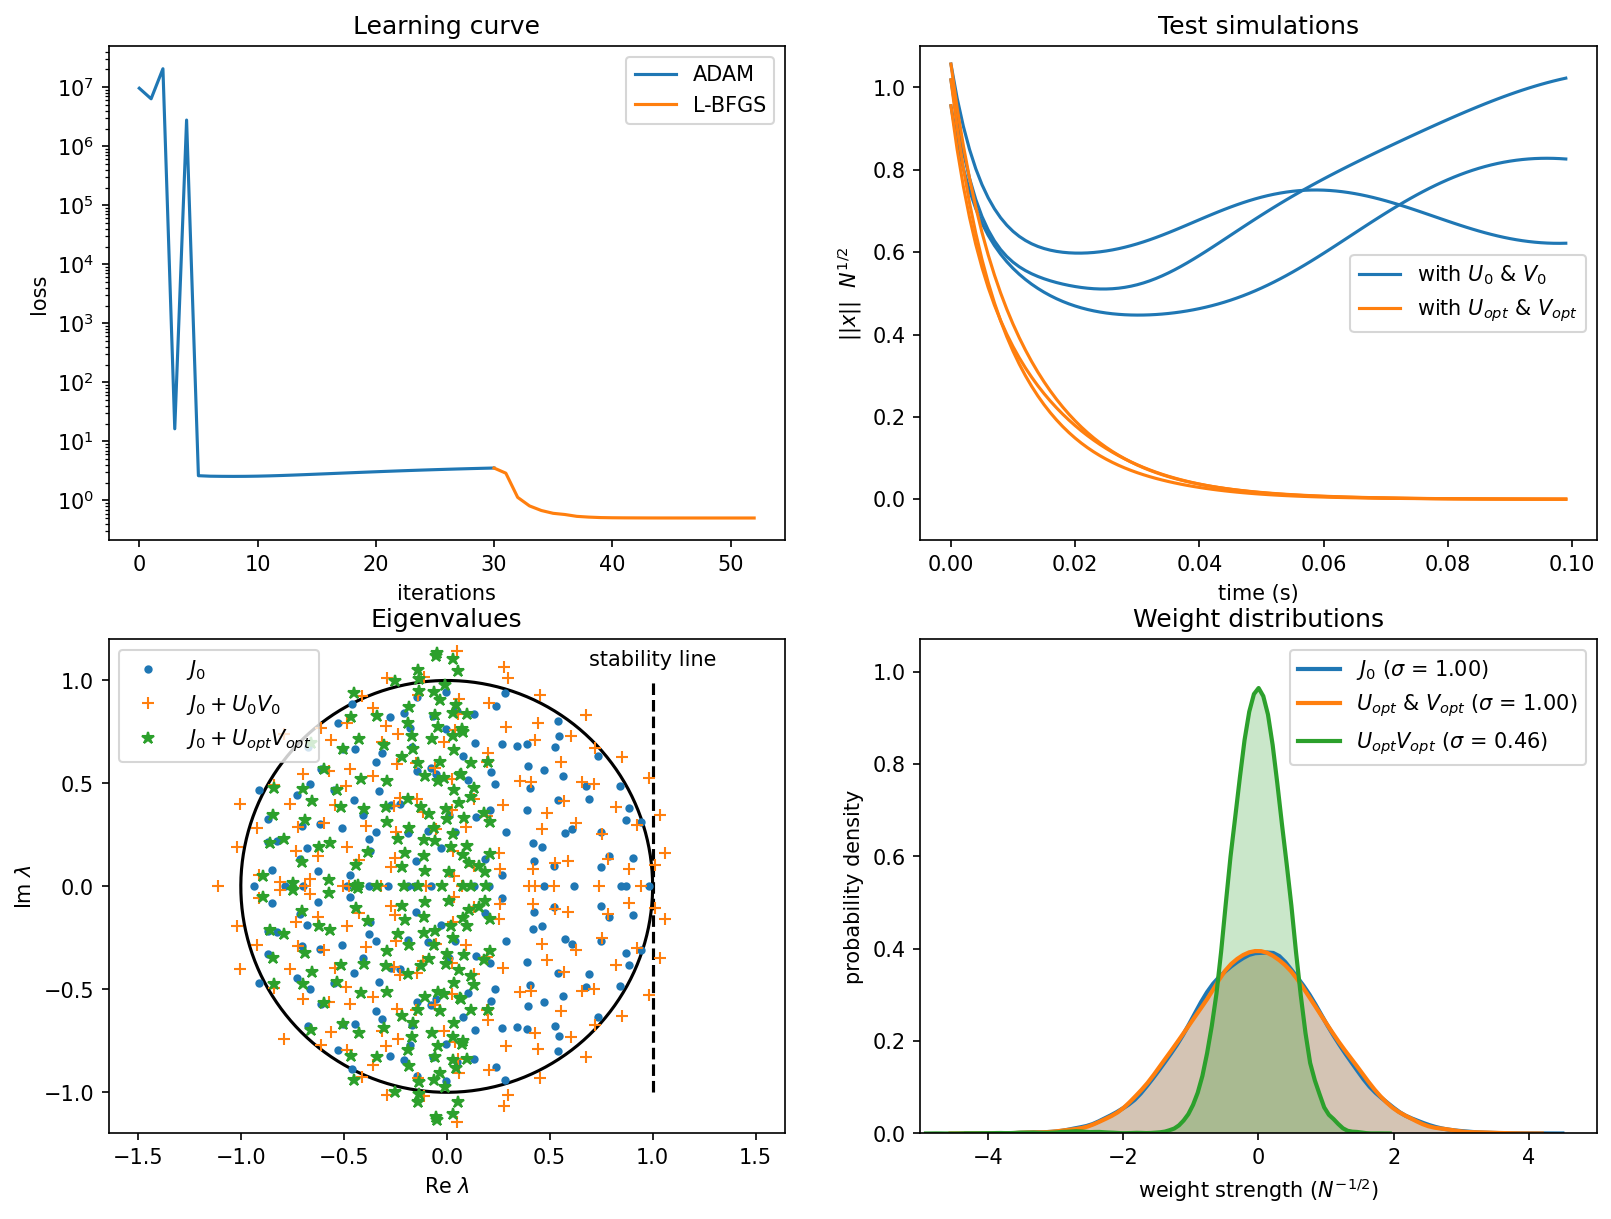

In [14]:
fig, axes = plt.subplots(2, 2, figsize=[6.4 * 2, 4.8 * 2])

# Learning curve
axes[0, 0].plot(losses[:adam_epochs + 1])
axes[0, 0].plot(np.arange(adam_epochs, len(losses)), losses[adam_epochs:])
axes[0, 0].set_yscale('log')
# axes[0, 0].set_ylim(0, 10)
axes[0, 0].set_xlabel('iterations')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend(['ADAM','L-BFGS'])
axes[0, 0].set_title('Learning curve')

# Norms of sample trajectories
axes[0, 1].plot(t, norms0_.T / N**0.5, color='tab:blue')
axes[0, 1].plot(t, norms_.T / N**0.5, color='tab:orange')
axes[0, 1].set_ylim(-0.1, 1.1)
axes[0, 1].set_xlabel('time (s)')
axes[0, 1].set_ylabel('$||x||$  $N^{1/2}$')
axes[0, 1].legend([axes[0, 1].get_children()[0], axes[0, 1].get_children()[test_runs]], ['with $U_0$ & $V_0$','with $U_{opt}$ & $V_{opt}$'])
axes[0, 1].set_title('Test simulations')

# Eigenvalues
axes[1, 0].plot(np.cos(theta), np.sin(theta), 'k')
axes[1, 0].plot([1, 1], [-1, 1], '--k')
h1 = axes[1, 0].plot(d.real, d.imag, '.')[0]
h2 = axes[1, 0].plot(d0.real, d0.imag, '+', fillstyle='none')[0]
h3 = axes[1, 0].plot(d_end.real, d_end.imag, '*')[0]
axes[1, 0].legend([h1, h2, h3], ['$J_0$', '$J_0 + U_0V_0$', '$J_0 + U_{opt}V_{opt}$'], loc='upper left')
axes[1, 0].set_xlabel('Re $\lambda$')
axes[1, 0].set_ylabel('Im $\lambda$')
axes[1, 0].text(1, 1.05, 'stability line', ha='center', va='bottom')
axes[1, 0].axis('equal')
axes[1, 0].set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
axes[1, 0].set_title('Eigenvalues')


# Weight distributions
sns.distplot(J0.flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = f'$J_0$ ($\sigma$ = {J0.flatten().std() * N**0.5:4.2f})', ax=axes[1, 1])
sns.distplot(np.concatenate((U_end, tf.transpose(V_end)), -1).flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = r'$U_{opt}$ & $V_{opt}$' + f' ($\sigma$ = {np.concatenate((U_end, tf.transpose(V_end)), -1).flatten().std() * N**0.5:4.2f})', ax=axes[1, 1])
sns.distplot((U_end @ V_end).numpy().flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = r"$U_{opt}V_{opt}$" + f" ($\sigma$ = {(U_end @ V_end).numpy().flatten().std() * N**0.5:4.2f})", ax=axes[1, 1])
sigmas = np.array([1, (N * sigma_U * sigma_V)**0.5, sigma_U * sigma_V * (n * N)**0.5])
axes[1, 1].set_xlim(-5 * sigmas.max(), 5 * sigmas.max())
axes[1, 1].set_ylim(0, 1.2 / sigmas.min() / (2 * np.pi)**0.5);
axes[1, 1].set_xlabel('weight strength ($N^{-1/2}$)')
axes[1, 1].set_ylabel('probability density')
axes[1, 1].set_title('Weight distributions');